#Twitter Sentiment Analysis

Aranged by StudentID-StudentName:

12S18033-Cristina Sriwahyuni Hasibuan

12S18038-Naomi A. Simatupang

12S18049-Natasya Sitorus

12S18060-Elsaday Bakara

##Requirements installation if not exist yet

In [ ]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 28 kB/s 
     |████████████████████████████████| 198 kB 45.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=b527a80bcc704c1994146d3e655857d3f05e0c91d0dce0c319ef73ff96a5ab75
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
pip install requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install tweepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install preprocessor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for preprocessor: filename=preprocessor-1.1.3-py3-none-any.whl size=4477 sha256=ff37c278099d3b59133f1d2f767679119108cc2f097bf8d15ad17471c006c666
  Stored in directory: /root/.cache/pip/wheels/0e/b7/36/aa37256db62b4bfd35a6f1b5536e9ba843f257b79dcbf3d5f1
Successfully built preprocessor


In [ ]:
pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Import Lib

In [62]:
import pyspark
from pyspark.sql import DataFrame
from pyspark.ml.classification import LogisticRegression, LinearSVC, NaiveBayes
import json
import csv
import nltk
from nltk.tokenize import word_tokenize
import re
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tweepy
from tweepy import OAuthHandler
from tweepy import Stream
from collections import Counter
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from pyspark.sql.types import StringType
from pyspark.sql.functions import col, udf
from pyspark.ml.feature import Tokenizer, StringIndexer, Word2Vec, StopWordsRemover, HashingTF
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [63]:
from wordcloud import WordCloud, STOPWORDS
from datetime import timedelta, datetime
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt 
from tweepy import OAuthHandler
from textblob import TextBlob
import preprocessor as p
import seaborn as sns
import pandas as pd
import numpy as np
import tweepy
import csv
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [64]:
# Import some libraries

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid')

import datetime as dt
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [65]:
import findspark
findspark.init()
import pyspark as ps
import warnings
from pyspark.sql import SQLContext

#Start a Session

In [66]:
#Memulai Spark Session
try:
    from pyspark.sql import SparkSession
    sc = ps.SparkContext('local[2]')
    sqlContext = SQLContext(sc)
    spark = SparkSession.builder \
      .master("local[2]") \
      .appName("Proyek_Sentiment Analysis") \
      .getOrCreate()
except ValueError:
    warnings.warn("SparkContext already exists in this scope")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: SparkContext already exists in this scope
  


In [67]:
spark

##Configuration

In [68]:
APIKey = "QnupptSEsqShuukhaPGsk0Svf"
APISecretKey = "HuD4bnPtEZcE1IVFDcluzuYcngbSMMYxKyfYA8MTXPUYZvn4N0"
AccessToken = "1390698546353999878-KExzyOWL2qm1zfmxZdrYmcnkaVbjue"
AccessTokenSecret = "dkEkoVa4QwW3Z8Rzvau6r37C7DhnUPU2zu91P6GZmm7Ec"
BearerToken ="AAAAAAAAAAAAAAAAAAAAALP5cAEAAAAACkdJeE7i23YH3L4qeYWpvoeqZAA%3DoOefkiPYcftGrIzdm9YgPi7hnYrI6ymuojs6031Dd5K5U7CWul"

In [69]:
TrackWords = ['covid']

In [70]:
today = datetime.today().strftime("%Y-%m-%d")
last_week = datetime.today() - timedelta(7)
last_week = last_week.strftime("%Y-%m-%d")

date_since = last_week
date_until = today

##Set Up

In [71]:
def connectOAuth():
    auth = OAuthHandler(APIKey, APISecretKey)
    auth.set_access_token(AccessToken, AccessTokenSecret)

    api = tweepy.API(auth, wait_on_rate_limit=True)
    return api

In [72]:
API = connectOAuth()

#Scrapping

In [73]:
def scraptweets(search_words, date_since, date_until):

    db_tweets = pd.DataFrame(columns=['username', 'tweetcreatedts', 'text'])

    tweets = tweepy.Cursor(
                    API.search,
                    q=search_words,
                    lang="id", 
                    since=date_since,
                    until=date_until,
                    tweet_mode='extended').items(5000)

    tweet_list = [tweet for tweet in tweets]

    for tweet in tweet_list:
        username = tweet.user.screen_name
        tweetcreatedts = tweet.created_at

        try:
            text = tweet.retweeted_status.full_text
        except AttributeError:
            text = tweet.full_text

        ith_tweet = [username, tweetcreatedts, text]

        db_tweets.loc[len(db_tweets)] = ith_tweet
    
    print('Proses Scrapping Selesai Dengan Jumlah Data', len(db_tweets))
    filename = 'reviews.csv'
    db_tweets.to_csv(filename, index=False)

In [74]:
scraptweets(TrackWords, date_since, date_until)

Proses Scrapping Selesai Dengan Jumlah Data 1621


#Load Raw Data Twitter

In [75]:
df = pd.read_csv('/content/reviews.csv', delimiter=",")

In [76]:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [77]:
df.describe()

,username,tweetcreatedts,text
count,1621,1621,1621
unique,1300,1575,813
top,sonia_rhm,2022-06-04 12:57:45,Beranikah pemerintah jujur bicara bahwa RS cov...
freq,24,3,395


In [78]:
df.head(10)

,username,tweetcreatedts,text
0,gwenkyute,2022-06-04 23:59:44,Kata Siapa Ekonomi Indonesia Menurun?\n\nSimak...
1,UrGirl_404Eror,2022-06-04 23:59:40,Setelah tau Jeno Chenle kena Covid dan member ...
2,lefthandtrader,2022-06-04 23:59:03,"@fmtoday Klu hadir di parlimen, ada alasan nak..."
3,TabananHumas,2022-06-04 23:58:46,Disiplin Prokes adalah kunci untuk mencegah pe...
4,TabananHumas,2022-06-04 23:58:37,Ayo vaksinasi Booster untuk meningkatkan imun ...
5,ridhorahadi,2022-06-04 23:58:33,Beranikah pemerintah jujur bicara bahwa RS cov...
6,r_waone,2022-06-04 23:58:17,Beranikah pemerintah jujur bicara bahwa RS cov...
7,wigRahman,2022-06-04 23:58:11,Beranikah pemerintah jujur bicara bahwa RS cov...
8,rizwanhafiz91,2022-06-04 23:58:06,SPRM | Graduan Institusi Pengajian Tinggi (IPT...
9,HexaSetya,2022-06-04 23:57:51,Beranikah pemerintah jujur bicara bahwa RS cov...


In [79]:
df.isnull().sum()

username          0
tweetcreatedts    0
text              0
dtype: int64

## Cleaning Tweets

In [80]:
df['text'].head(10)

0    Kata Siapa Ekonomi Indonesia Menurun?\n\nSimak...
1    Setelah tau Jeno Chenle kena Covid dan member ...
2    @fmtoday Klu hadir di parlimen, ada alasan nak...
3    Disiplin Prokes adalah kunci untuk mencegah pe...
4    Ayo vaksinasi Booster untuk meningkatkan imun ...
5    Beranikah pemerintah jujur bicara bahwa RS cov...
6    Beranikah pemerintah jujur bicara bahwa RS cov...
7    Beranikah pemerintah jujur bicara bahwa RS cov...
8    SPRM | Graduan Institusi Pengajian Tinggi (IPT...
9    Beranikah pemerintah jujur bicara bahwa RS cov...
Name: text, dtype: object

In [81]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers

    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

def casefoldingText(text): # Converting all the characters in a text into lower case
    text = text.lower() 
    return text

def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text) 
    return text

def filteringText(text): # Remove stopwors in a text
    listStopwords = set(pd.read_csv('/content/stopwords-id.txt'))
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered 
    return text

def toSentence(list_words): # Convert list of words into sentence
    sentence = ' '.join(word for word in list_words)
    return sentence

In [82]:
# Preprocessing tweets data

df['text_clean'] = df['text'].apply(cleaningText)
df['text_clean'] = df['text_clean'].apply(casefoldingText)
df.drop(['text'], axis = 1, inplace = True)

df['text_preprocessed'] = df['text_clean'].apply(tokenizingText)
df['text_preprocessed'] = df['text_preprocessed'].apply(filteringText)
df['tweets'] = df['text_preprocessed'].apply(toSentence)

# drop duplicates/spams tweets
df.drop_duplicates(subset = 'tweets', inplace = True)

df.drop(['text_clean', 'text_preprocessed'], axis = 1, inplace = True)

In [83]:
df.count()

username          693
tweetcreatedts    693
tweets            693
dtype: int64

#Labeling Data

In [84]:
from textblob import TextBlob
def sentiment_calc(tweets):
    p = TextBlob(tweets).sentiment.polarity
    if p<0 :
        return("negatif")
    elif p>0 :
        return("positif")
    else:
        return("netral")

df['sentiment'] = df['tweets'].apply(sentiment_calc)

In [85]:
df["sentiment"].describe()

count        693
unique         3
top       netral
freq         626
Name: sentiment, dtype: object

In [86]:
filename = 'preprocessed_tweets.csv'
df.to_csv(filename, index=False)

#DataFrame Pyspark SQL

In [87]:
df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('/content/preprocessed_tweets.csv')
type(df)

pyspark.sql.dataframe.DataFrame

In [88]:
df.show(5)

+--------------+-------------------+--------------------+---------+
|      username|     tweetcreatedts|              tweets|sentiment|
+--------------+-------------------+--------------------+---------+
|     gwenkyute|2022-06-04 23:59:44|kata siapa ekonom...|   netral|
|UrGirl_404Eror|2022-06-04 23:59:40|setelah tau jeno ...|   netral|
|lefthandtrader|2022-06-04 23:59:03|klu hadir di parl...|   netral|
|  TabananHumas|2022-06-04 23:58:46|disiplin prokes a...|   netral|
|  TabananHumas|2022-06-04 23:58:37|ayo vaksinasi boo...|   netral|
+--------------+-------------------+--------------------+---------+
only showing top 5 rows



In [89]:
df = df.dropna()
df.count()

693

#Split Train Test

In [90]:
df.describe()

DataFrame[summary: string, username: string, tweetcreatedts: string, tweets: string, sentiment: string]

In [91]:
(train_set, val_set, test_set) = df.randomSplit([0.80, 0.10, 0.10], seed = 1103)

#HashingTF + IDF + Logistic Regression

In [92]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol="tweets", outputCol="words")
hashtf = HashingTF(numFeatures=262144, inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "sentiment", outputCol = "label")
pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx])

pipelineFit = pipeline.fit(train_set)
train_df = pipelineFit.transform(train_set)
val_df = pipelineFit.transform(val_set)
train_df.show(5)

+--------+-------------------+--------------------+---------+--------------------+--------------------+--------------------+-----+
|username|     tweetcreatedts|              tweets|sentiment|               words|                  tf|            features|label|
+--------+-------------------+--------------------+---------+--------------------+--------------------+--------------------+-----+
| 0509Kab|2022-06-04 13:29:32|kegiatan doa keba...|   netral|[kegiatan, doa, k...|(262144,[11395,20...|(262144,[11395,20...|  0.0|
|   07TO_|2022-06-04 22:38:27|loona kalo perfor...|  negatif|[loona, kalo, per...|(262144,[6121,113...|(262144,[6121,113...|  2.0|
|095pages|2022-06-04 13:29:54|happy ketemu teme...|  positif|[happy, ketemu, t...|(262144,[5394,113...|(262144,[5394,113...|  1.0|
| 1224ist|2022-06-04 12:54:41| aku ga covid anjing|   netral|[aku, ga, covid, ...|(262144,[11395,36...|(262144,[11395,36...|  0.0|
|   18v92|2022-06-04 18:30:41|yg nombokin penur...|   netral|[yg, nombokin, pe...|(

In [93]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(maxIter=100)
lrModel = lr.fit(train_df)
predictions = lrModel.transform(val_df)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator()
evaluator.evaluate(predictions)

0.8306459868959869

In [94]:
%%time
from pyspark.ml.feature import CountVectorizer

tokenizer = Tokenizer(inputCol="tweets", outputCol="words")
cv = CountVectorizer(vocabSize=262144, inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "sentiment", outputCol = "label")
lr = LogisticRegression(maxIter=100)
pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, lr])

pipelineFit = pipeline.fit(train_set)
predictions = pipelineFit.transform(val_set)
Taccuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
Troc_auc = evaluator.evaluate(predictions)

print ("Accuracy Score: {0:.4f}".format(Taccuracy))
print ("ROC-AUC: {0:.4f}".format(Troc_auc))

Accuracy Score: 0.7969
ROC-AUC: 0.8306
CPU times: user 99.6 ms, sys: 12.7 ms, total: 112 ms
Wall time: 3.86 s


In [95]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
accuracy

0.796875

#CountVectorizer + IDF + Logistic Regression

In [96]:
%%time
from pyspark.ml.feature import CountVectorizer

tokenizer = Tokenizer(inputCol="tweets", outputCol="words")
cv = CountVectorizer(vocabSize=262144, inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "sentiment", outputCol = "label")
lr = LogisticRegression(maxIter=100)
pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, lr])

pipelineFit = pipeline.fit(train_set)
predictions = pipelineFit.transform(val_set)
Caccuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
Croc_auc = evaluator.evaluate(predictions)

print ("Accuracy Score: {0:.4f}".format(Caccuracy))
print ("ROC-AUC: {0:.4f}".format(Croc_auc))

Accuracy Score: 0.7969
ROC-AUC: 0.8306
CPU times: user 111 ms, sys: 13.2 ms, total: 125 ms
Wall time: 3.83 s


#N Gram

In [97]:
from pyspark.ml.feature import NGram, VectorAssembler
from pyspark.ml.feature import ChiSqSelector

def build_trigrams(inputCol=["tweets","sentiment"], n=3):
    tokenizer = [Tokenizer(inputCol="tweets", outputCol="words")]
    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    cv = [
        CountVectorizer(vocabSize=262144,inputCol="{0}_grams".format(i),
            outputCol="{0}_tf".format(i))
        for i in range(1, n + 1)
    ]
    idf = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]

    assembler = [VectorAssembler(
        inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
        outputCol="rawFeatures"
    )]
    label_stringIdx = [StringIndexer(inputCol = "sentiment", outputCol = "label")]
    selector = [ChiSqSelector(numTopFeatures=50,featuresCol='rawFeatures', outputCol="features")]
    lr = [LogisticRegression(maxIter=100)]
    return Pipeline(stages=tokenizer + ngrams + cv + idf+ assembler + label_stringIdx+selector+lr)

In [98]:
%%time
trigram_pipelineFit = build_trigrams().fit(train_set)
predictions = trigram_pipelineFit.transform(val_set)
Naccuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
Nroc_auc = evaluator.evaluate(predictions)
# print accuracy, roc_auc
print ("Accuracy Score: {0:.4f}".format(Naccuracy))
print ("ROC-AUC: {0:.4f}".format(Nroc_auc))

Accuracy Score: 0.8750
ROC-AUC: 0.8744
CPU times: user 363 ms, sys: 45.4 ms, total: 408 ms
Wall time: 24.7 s


#N Gram Tanpa without Chi Squared feature selection

In [99]:
def build_ngrams_wocs(inputCol=["tweets","sentiment"], n=3):
    tokenizer = [Tokenizer(inputCol="tweets", outputCol="words")]
    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    cv = [
        CountVectorizer(vocabSize=262144,inputCol="{0}_grams".format(i),
            outputCol="{0}_tf".format(i))
        for i in range(1, n + 1)
    ]
    idf = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]

    assembler = [VectorAssembler(
        inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
        outputCol="features"
    )]
    label_stringIdx = [StringIndexer(inputCol = "sentiment", outputCol = "label")]
    lr = [LogisticRegression(maxIter=100)]
    return Pipeline(stages=tokenizer + ngrams + cv + idf+ assembler + label_stringIdx+lr)

In [100]:
%%time
trigramwocs_pipelineFit = build_ngrams_wocs().fit(train_set)
predictions_wocs = trigramwocs_pipelineFit.transform(val_set)
accuracy_wocs = predictions_wocs.filter(predictions_wocs.label == predictions_wocs.prediction).count() / float(val_set.count())
roc_auc_wocs = evaluator.evaluate(predictions_wocs)
# print accuracy, roc_auc
print ("Accuracy Score: {0:.4f}".format(accuracy_wocs))
print ("ROC-AUC: {0:.4f}".format(roc_auc_wocs))

Accuracy Score: 0.7656
ROC-AUC: 0.8124
CPU times: user 316 ms, sys: 44.3 ms, total: 360 ms
Wall time: 15.8 s


In [101]:
test_predictions = trigramwocs_pipelineFit.transform(test_set)
test_accuracy = test_predictions.filter(test_predictions.label == test_predictions.prediction).count() / float(test_set.count())
test_roc_auc = evaluator.evaluate(test_predictions)
# print accuracy, roc_auc
print ("Accuracy Score: {0:.4f}".format(test_accuracy))
print ("ROC-AUC: {0:.4f}".format(test_roc_auc))

Accuracy Score: 0.7581
ROC-AUC: 0.7825


#Visualisasi Sentimen Tweet Bahasa Indonesia Mengenai Covid

In [102]:
import pyspark.sql.functions as func
sentiment = df.groupBy('sentiment').count().select(func.col("sentiment").alias("distinct_sentiment"),func.col("count").alias("country_sentiment"))
sentiment.show()

+------------------+-----------------+
|distinct_sentiment|country_sentiment|
+------------------+-----------------+
|           negatif|               25|
|           positif|               42|
|            netral|              626|
+------------------+-----------------+



In [104]:
sentiment.write.parquet("/senti.parquet")

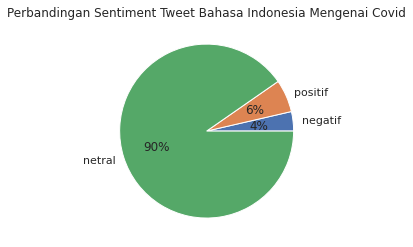

In [105]:
import matplotlib.pyplot as plt

senti = sentiment.toPandas()

fig = plt.pie(senti['country_sentiment'], labels=senti['distinct_sentiment'], autopct='%.0f%%')
plt.title('Perbandingan Sentiment Tweet Bahasa Indonesia Mengenai Covid')
plt.show()  

In [107]:
# from google.colab import files
# files.download("/content/preprocessed_tweets.csv")
# files.download("/content/reviews.csv")
# files.download("/content/stopwords-id.txt")

In [106]:
spark.stop()